In [1]:
import math                                 #for math.ceil()
from typing import List, Dict               #for annotation
import matplotlib.pyplot as plt

#Function, that return file content as list of string
def Read_file(fname : str)->List[str]:
    f = None
    data = []
    try:
        f = open(fname)
        for line in f:
            data.append(line)
    finally:
        if f != None:
            f.close()
        else:
            print('File error')
        return data
    
#The Read_block() function return List of string contain sub-block starting at prescribed line, 
#define type of sub-block and call necessary reading function

def Read_block(NLine:int, data:List[str])->List[str]:
    #get block id from first two numbers in second line
    NE  = int(data[NLine+1][0:3])
    NTE = int(data[NLine+1][3:6])
    print(NE,NTE)
    if NE == 0 and NTE == 0:
        print('Airfoil')
        ret_data = Read_Airfoil(NLine, data)
    if NE != 0:
        if abs(NTE) == 1:
            print('Body at line: ', NLine)
            ret_data = Read_Body(NLine, data)
        if abs(NTE) == 2:
            print('Wing at line: ', NLine)
            ret_data = Read_Wing(NLine, data)
        if abs(NTE) == 3:
            print('Engine nacelle at line: ', NLine)
            ret_data = Read_Nacelle(NLine, data)
        if abs(NTE) == 4: 
            print('Jet at line:', NLine)
            ret_data = Read_Jet(NLine, data)
    if NE < 0:
        print('This is a last item in the file at line: ', NLine)
    return ret_data

#The Control_Line() function return a list of int with control numbers from string passed in
def Control_Line(cstr:str)->List[int]:
    cList = [0]*20             #20 seems more than enough, manual is report at max 17 numbers in control string
    cstr = cstr.rstrip()       #trim right side spaces
    maxlen = math.ceil(len(cstr)/3)
    for i in range(maxlen):
        try:
            cList[i] = int(cstr[0:3])
        except:
            pass
        cstr = cstr[3:]
    return cList

#Τhe Read_Airfoil() function calculate lines count of airfoil block and return these lines
def Read_Airfoil(NLine:int, data:List[str])->List[str]:
    #Read second line in block, sequence of int
    cList = Control_Line(data[NLine+1])
    NP = cList[2]      #Number of airfoil
    ITBE = cList[3]    #Specify type of coordinate defenition
    IK = cList[4]      #Leading edge index ???
    NU = cList[5]      #Point count
    IS = cList[6]      #Symmetry flag
    IM = cList[7]      #Rescale flag
    IP = cList[8]      #Rotation flag
    #Block size calculation
    LineCount = 3      #Header, control line, commentary
    if ITBE in (0,1):
        n = 3
    if ITBE == 2:
        n = 2
    LineCount += n+n*math.ceil(NU/10)
    if IM == 1 or IP == 1:
        LineCount +=2
    return data[NLine:(NLine+LineCount)]

#Τhe Read_Body() function calculate lines count of body (fuselage, some nacelle) block and return these lines
def Read_Body(NLine:int, data:List[str])->List[str]:
    #Read second line in block, sequence of int
    cList = Control_Line(data[NLine+1])
    ITBE   = cList[2]    #Specify type of coordinate definition
    NSE    = cList[3]    #Sections count
    NU     = cList[4]    #Points per section
    IIPPC  = cList[5]    #Change sections flag
    NSEI   = cList[6]    #New sections count
    INUT   = cList[7]    #Change points flag
    NUI    = cList[8]    #New points count
    ICHAR  = cList[9]    #Reference values for normalization
    IMASH  = cList[10]   #Rescale flag
    IPREOB = cList[11]   #Rotate and translate
    #Block size calculation
    LineCount = 3      #Header, control line, commentary
    if ITBE == 0:
        LineCount += 1
        LineCount += 3*NSE*math.ceil(NU/10)
    elif ITBE == 1:
        LineCount += 1
        LineCount += math.ceil(NSE/10)
        LineCount += 1
        LineCount += 2*NSE*math.ceil(NU/10)
    elif ITBE == 2:
        LineCount += 4
        LineCount += 4*math.ceil(NSE/10)
    if IIPC != 0 and NSEI != 0:
        LineCount += 1
        LineCount += math.ceil(NSEI/10)
    #If Reference values is specify
    if ICHAR != 0:
        LineCount += 2
    #Rescale
    if IMASH != 0:
        LineCount += 2
    #Rotate and translate
    if IPREOB != 0:
        LineCount += 2
    return data[NLine:(NLine+LineCount)]

#The Read_Wing() function calculate lines count of wing block and return these lines
def Read_Wing(NLine:int, data:List[str])->List[str]:
    #Read second line in block, sequence of int
    cList = Control_Line(data[NLine+1])
    ITBE   = cList[2]     #Wing definition type
    NSE    = cList[3]     #Spanwise section count
    NU     = cList[4]     #Points chordwise
    IIPC   = cList[5]     #Reinterpolate section
    NSEI   = cList[6]     #New section count
    INUI   = cList[7]     #don't used for wing
    NLIP   = cList[8]     #wake panel count per strip
    ICHAR  = cList[9]     #Reference values for normalization
    IMASH  = cList[10]    #Rescale flag
    IPREOB = cList[11]    #Resize and translate
    #Block size calculation
    LineCount = 3      #Header, control line, commentary
    LineCount += NSE*2
    if NU > 0:
        LineCount += 1+math.ceil(NU/10)
    if IIPC == 1 and NSEI != 0:
        LineCount += 1+math.ceil(NSEI/10)
    #If Reference values is specify
    if ICHAR != 0:
        LineCount += 2
    #Rescale
    if IMASH != 0:
        LineCount += 2
    #Rotate and translate
    if IPREOB != 0:
        LineCount += 2
    return data[NLine:(NLine+LineCount)]    

#The Read_Nacelle() function calculate lines count of nacelle block and return these lines
def Read_Nacelle(NLine:int, data:List[str])->List[str]:
    #Read second line in block, sequence of int
    cList = Control_Line(data[NLine+1])
    ITBE   = cList[2]     #Nacelle definition type
    NSE    = cList[3]     #Nacelle section count
    NU     = cList[4]     #Points per section
    IIPC   = cList[5]     #Reinterpolate section
    NSEI   = cList[6]     #New section count
    NUI   = cList[7]      #New point per section
    NLIP   = cList[8]     #wake panel count per strip
    ICHAR  = cList[9]     #Reference values for normalization
    IMASH  = cList[10]    #Rescale flag
    IPREOB = cList[11]    #Resize and translate
    #Block size calculation
    LineCount = 3      #Header, control line, commentary
    if ITBE == 1:
        LineCount += 3 + 3*math.ceil(NSE/10)
        LineCount += (1+ 4*math.ceil(NU/10))*NSE
    #If Reference values is specify
    if ICHAR != 0:
        LineCount += 2
    #Rescale
    if IMASH != 0:
        LineCount += 2
    #Rotate and translate
    if IPREOB != 0:
        LineCount += 2
    return data[NLine:(NLine+LineCount)]    

#The Read_Jet() function calculate lines count of jet block and return these lines
def Read_Jet(NLine:int, data:List[str])->List[str]:
    #Read second line in block, sequence of int
    cList = Control_Line(data[NLine+1])
    ITBE   = cList[2]     #Jet definition type
    NSE    = cList[3]     #Jet section count
    NU     = cList[4]     #Points per section
    IIA    = cList[5]     #Active section flag
    NSEA   = cList[6]     #Nacelle section N with jet active section
    NRRA   = cList[7]     #Points per active section radius
    ISJ    = cList[8]     #Jet symmetry flag
    NJOHV  = cList[9]     #Outer jet number
    IEJ    = cList[10]    #Jet coupled with nacelle flag
    NEG    = cList[11]    #Nacelle N coupled with jet
    #Block size calculation
    LineCount = 3      #Header, control line, commentary
    if ITBE == 1:
        LineCount += 2
    if IIA == 1:
        LineCount += 2
    return data[NLine:(NLine+LineCount)]    

In [2]:
#Startline position
N_START = 6-1
#Blocknumber
N = 1
#Empty dictionary of blocks
aDict = {int:List[str]}

#Filename
folder = "D:\\Проекты\\Аэропракт А-8 в PANSYM\\Расчетные модели PANSYM"
filename = folder + "\\A8.in"

#Read 1st block and add to dictionary
data_item = Read_block(N_START, Read_file(filename))
aDict[N] = data_item
#Read next if exist
while (len(data_item)!=0) and (int(data_item[1][0:3])>=0):
    N_START += len(data_item)
    data_item = Read_block(N_START, Read_file(filename))
    N+=1
    if data_item == []:
        break
    aDict[N]=data_item
    if int(data_item[1][0:3])<0:
        break

print()
print('Print header of all readed blocks: ')        
print()
for i in range(1,len(list(aDict.keys()))):
    print(aDict[i][0])
print()
print('Last line of last blocks:')
print(aDict[len(list(aDict.keys()))-1][-1])
    

0 0
Airfoil
0 0
Airfoil
1 2
Wing at line:  38
-2 2
Wing at line:  48
This is a last item in the file at line:  48

Print header of all readed blocks: 

RAF-32

FX-60-126

#First_wing

#Second_wing


Last line of last blocks:
  .6    .7     .8    .9      .95    1.0



In [3]:
#The Coords() function return list of float from string
def Str2Coords(input_str:str, count:int)->List[float]:
    cList = []
    if count > 10:
        count = 10
    if count < 1:
        count = 1
    for i in range(0,count*7,7):
        #print(i)
        #print(input_str[i:i+7])
        try:
            cList.append(float(input_str[i:i+7]))
        except:
            cList.append(0.0)
    return cList

#The Block2Coords return list of float from block of string
def Block2Coords(data:List[str],NU:int)->List[float]:
    cList = []
    for i in range(math.ceil(NU/10)):
        if (i+1)*10 > NU:
            count = NU%10
        else:
            count = 10
        cList.extend(Str2Coords(data[i],count))
    return cList

#The Airfoil_plot() show matplotlib plot of airfoil from list of string
def Airfoil_plot(data:List[str]):
    cList = Control_Line(data[1])
    ITBE = cList[3]
    NU = cList[5]
    lines = math.ceil(NU/10)
    ax = plt.gca()
    ax.axis('equal')
    X  = Block2Coords(data[4:4+lines],NU)
    if ITBE == 0:
        Y1 = Block2Coords(data[4+lines+1:4+1+lines*2],NU)
        Y2 = Block2Coords(data[4+2+lines*2:4+2+lines*3],NU)
        plt.plot(X,Y1)
        plt.plot(X,Y2)
    if ITBE == 1:
        Y_m = Block2Coords(data[4+lines+1:4+1+lines*2],NU)
        Y_t = Block2Coords(data[4+2+lines*2:4+2+lines*3],NU)
        plt.plot(X,Y_m,':')
        Y1 = list(map(lambda x,y: x+y,Y_m,Y_t))
        Y2 = list(map(lambda x,y: x-y,Y_m,Y_t))
        plt.plot(X,Y1)
        plt.plot(X,Y2)        
    if ITBE == 2:
        Y = Block2Coords(data[4+lines+1:4+1+lines*2],NU)
        plt.plot(X,Y)
    plt.show()

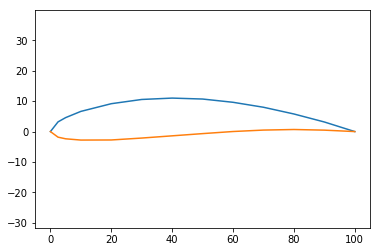

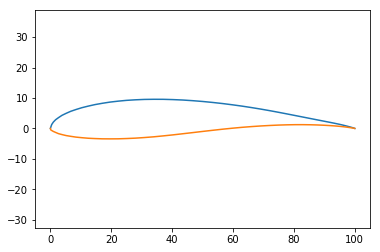

In [4]:
Airfoil_plot(aDict[1])
Airfoil_plot(aDict[2])

RAF-32

0


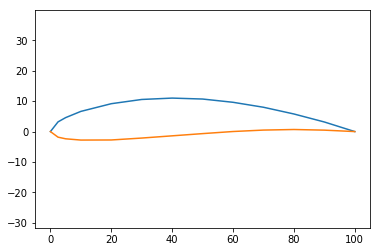

FX-60-126

0


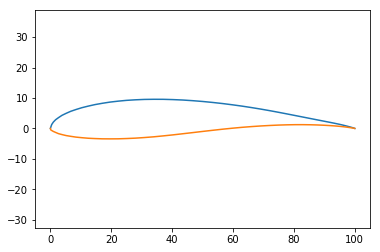

In [5]:
class Airfoil():
    def __init__(self,data:List[str]):
        self.name = data[0]
        self.text = data
        self.points = Control_Line(data[1])[5]
        self.type = Control_Line(data[1])[3]
        
    def plot(self):
        Airfoil_plot(self.text)
        
lstAirfoils = []
for i in range(1,len(list(aDict.keys()))):
    type = Control_Line(aDict[i][1])[1]
    if type == 0:
        lstAirfoils.append(Airfoil(aDict[i]))
        
for i in range(len(lstAirfoils)):
    print(lstAirfoils[i].name)
    print(lstAirfoils[i].type)
    lstAirfoils[i].plot()